# Modeling

### Import Relevant Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer, snowball
from nltk.corpus import stopwords
from nltk import FreqDist
from wordcloud import WordCloud
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.util import ngrams
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder 
from nltk.util import ngrams

nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import plot_confusion_matrix, classification_report, r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

import time

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\capta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Read in Processed Data

In [2]:
df = pd.read_parquet('./Data/processed_reports.parquet')

In [3]:
df.reset_index(inplace=True)

In [4]:
df.drop(['index'],axis=1,inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Data columns (total 99 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   player                       4209 non-null   object 
 1   report                       4209 non-null   object 
 2   year                         4209 non-null   float64
 3   weight_x                     3986 non-null   float64
 4   height_x                     3986 non-null   float64
 5   pos_rk                       3871 non-null   float64
 6   ovr_rk                       3292 non-null   float64
 7   grade                        3877 non-null   float64
 8   age                          3897 non-null   float64
 9   Round                        4209 non-null   Int64  
 10  Pick                         4209 non-null   Int64  
 11  target                       4209 non-null   Int64  
 12  processed_report             4209 non-null   object 
 13  reportlen         

In [6]:
df['target'] = df.Round

In [7]:
df.target[df.target >= 6] = 0

In [8]:
df.target[df.target == 1] = 10

In [9]:
df.target[(df.target == 4) | (df.target == 5)] = 1

In [10]:
df.target[df.target == 3] = 2

In [11]:
df.target[df.target == 10] = 3

In [12]:
cleaned_df = df.drop(['report','processed_report','joined_report','weight_y','height_y'],axis=1) 

In [13]:
cleaned_df = cleaned_df.add_suffix('_col')

In [14]:
cleaned_df

,player_col,year_col,weight_x_col,height_x_col,pos_rk_col,ovr_rk_col,grade_col,age_col,Round_col,Pick_col,...,tackles_loss_career_col,sacks_career_col,pass_defended_career_col,fumbles_forced_season_col,fumbles_forced_career_col,college_conference_col,speed_col,shuttle_agility_col,cone_agility_col,pos_col
0,Alex Smith,2005.0,217.0,76.125,2.0,3.0,98.0,21.0,1,1,...,NaN,NaN,NaN,NaN,NaN,Mountain West Conference,88.187311,176.485482,136.815911,QB
1,Ronnie Brown,2005.0,233.0,72.250,1.0,4.0,98.0,23.0,1,2,...,NaN,NaN,NaN,NaN,NaN,None,120.996000,168.168738,130.199966,RB
2,Braylon Edwards,2005.0,211.0,74.875,1.0,1.0,99.0,22.0,1,3,...,NaN,NaN,NaN,NaN,NaN,None,107.614900,NaN,NaN,WR
3,Cedric Benson,2005.0,222.0,70.500,3.0,10.0,96.0,22.0,1,4,...,NaN,NaN,NaN,NaN,NaN,None,97.457455,NaN,NaN,RB
4,Carnell Williams,2005.0,217.0,70.875,2.0,6.0,97.0,NaN,1,5,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,RB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,Jeff Gunter,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,252,...,38.5,17.0,4.0,2.0,9.0,Sun Belt Conference,105.744617,144.109521,137.671457,LB
4205,Trenton Gill,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,255,...,NaN,NaN,NaN,NaN,NaN,Atlantic Coast Conference,NaN,NaN,NaN,P
4206,Jesse Luketa,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,256,...,11.5,0.5,6.0,NaN,NaN,Big Ten Conference,88.494256,NaN,NaN,LB
4207,Marquis Hayes,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,257,...,NaN,NaN,NaN,NaN,NaN,Big Twelve Conference,80.603451,NaN,NaN,OL


In [15]:
tf = TfidfVectorizer(ngram_range=(1,3),min_df=.062,max_df =.75)

In [16]:
X = tf.fit_transform(df.joined_report)

In [17]:
report_df = pd.DataFrame(X.toarray(),columns=tf.get_feature_names())

In [18]:
report_df.columns

Index(['2002', '2003', '2004', '2005', '2006', '2016', 'abil', 'adequ', 'also',
       'appear',
       ...
       'two season', 'upsid', 'valu', 'versatil', 'well', 'work', 'yard',
       'year', 'year starter', 'zone'],
      dtype='object', length=198)

In [19]:
model_df = pd.concat([cleaned_df,report_df],axis=1)

In [20]:
model_df

,player_col,year_col,weight_x_col,height_x_col,pos_rk_col,ovr_rk_col,grade_col,age_col,Round_col,Pick_col,...,two season,upsid,valu,versatil,well,work,yard,year,year starter,zone
0,Alex Smith,2005.0,217.0,76.125,2.0,3.0,98.0,21.0,1,1,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.302746,0.197995,0.0,0.000000
1,Ronnie Brown,2005.0,233.0,72.250,1.0,4.0,98.0,23.0,1,2,...,0.0,0.0,0.0,0.128312,0.0,0.130273,0.338669,0.000000,0.0,0.000000
2,Braylon Edwards,2005.0,211.0,74.875,1.0,1.0,99.0,22.0,1,3,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.261304,0.113928,0.0,0.000000
3,Cedric Benson,2005.0,222.0,70.500,3.0,10.0,96.0,22.0,1,4,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.200609,0.000000,0.0,0.000000
4,Carnell Williams,2005.0,217.0,70.875,2.0,6.0,97.0,NaN,1,5,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.282241,0.061528,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,Jeff Gunter,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,252,...,0.0,0.0,0.0,0.199357,0.0,0.000000,0.000000,0.000000,0.0,0.000000
4205,Trenton Gill,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,255,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.370394,0.000000,0.0,0.000000
4206,Jesse Luketa,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,256,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
4207,Marquis Hayes,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,257,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.237427


### Linear Regression

In [21]:
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('lin',LinearRegression())
])

grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
}

lin = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [22]:
lin.fit(X_train,y_train)
y_pred = lin.predict(X_test)
print(r2_score(y_test,y_pred),mean_squared_error(y_test,y_pred));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\a

0.4901565629798307 2530.820585660758


(0.0, 270.0)

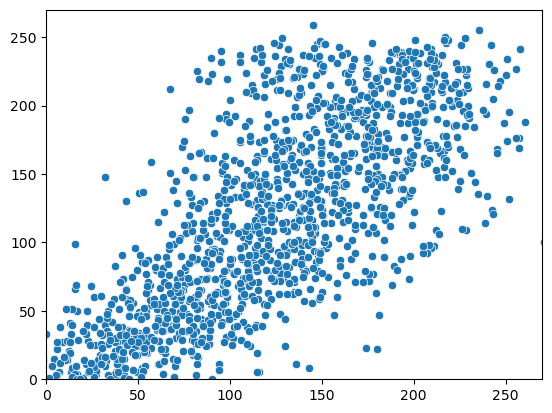

In [23]:
sns.scatterplot(y_pred,y_test)
plt.xlim(0,270)
plt.ylim(0,270)

### Random Forest

In [108]:
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col
player_pos = X_test.pos_col

X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

rfc_pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('forest',RandomForestRegressor())
])

rfc_pipe.fit(X_train, y_train)

grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'forest__n_estimators':[102],
#     'forest__criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'forest__max_depth':[24],
    'forest__min_samples_split':[2],
    'forest__min_samples_leaf':[6]
}

forest = GridSearchCV(estimator=rfc_pipe,
                          param_grid=grid,
                          cv=5)

In [111]:
start_time = time.time()
forest.fit(X_train,y_train)
print(((time.time() - start_time)/60),'minutes')
y_pred_forest = forest.predict(X_test)
print(r2_score(y_test,y_pred_forest),mean_squared_error(y_test,y_pred_forest));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\a

3.1528910597165427 minutes
0.6613585026228281 1680.9883397346264


In [114]:
rfc_pipe[0].transformers_[1][1].named_steps['ohe'].get_feature_names()

array(['x0_Atlantic Coast Conference', 'x0_Big East',
       'x0_Big Sky Conference', 'x0_Big South Conference',
       'x0_Big Ten Conference', 'x0_Big Twelve Conference',
       'x0_Central Intercollegiate Athletic Association',
       'x0_Colonial Athletic Association', 'x0_Conference USA',
       'x0_Great Lakes Intercollegiate Athletic Conference',
       'x0_Great Northwest Athletic Conference',
       'x0_Great West Football Conference', 'x0_Gulf South Conference',
       'x0_Independent', 'x0_Ivy League', 'x0_Lone Star Conference',
       'x0_Mid-America Intercollegiate Athletic Association',
       'x0_Mid-American Conference', 'x0_Mid-Eastern Athletic Conference',
       'x0_Minnesota Intercollegiate Athletic Conference',
       'x0_Missouri Valley Football Conference',
       'x0_Mountain West Conference', 'x0_Northeast Conference',
       'x0_Northern Sun Intercollegiate Conference',
       'x0_Ohio Athletic Conference', 'x0_Ohio Valley Conference',
       'x0_Pacific Twelv

In [118]:
X_train.columns.to_list()

['weight_x_col',
 'height_x_col',
 'pos_rk_col',
 'ovr_rk_col',
 'grade_col',
 'age_col',
 'reportlen_col',
 'forty_yd_col',
 'vertical_col',
 'bench_reps_col',
 'broad_jump_col',
 'cone_col',
 'shuttle_col',
 'g_season_col',
 'def_int_season_col',
 'def_int_yds_season_col',
 'def_int_yds_per_int_season_col',
 'def_int_career_col',
 'def_int_yds_career_col',
 'def_int_yds_per_int_career_col',
 'pass_cmp_season_col',
 'pass_att_season_col',
 'pass_cmp_pct_season_col',
 'pass_yds_season_col',
 'pass_yds_per_att_season_col',
 'adj_pass_yds_per_att_season_col',
 'pass_td_season_col',
 'pass_int_season_col',
 'pass_rating_season_col',
 'pass_cmp_career_col',
 'pass_att_career_col',
 'pass_cmp_pct_career_col',
 'pass_yds_career_col',
 'pass_yds_per_att_career_col',
 'adj_pass_yds_per_att_career_col',
 'pass_td_career_col',
 'pass_int_career_col',
 'pass_rating_career_col',
 'rush_att_season_col',
 'rush_yds_season_col',
 'rush_yds_per_att_season_col',
 'rush_td_season_col',
 'rec_season_col'

In [120]:
feature_cols = ['weight_x_col',
 'height_x_col',
 'pos_rk_col',
 'ovr_rk_col',
 'grade_col',
 'age_col',
 'reportlen_col',
 'forty_yd_col',
 'vertical_col',
 'bench_reps_col',
 'broad_jump_col',
 'cone_col',
 'shuttle_col',
 'g_season_col',
 'def_int_season_col',
 'def_int_yds_season_col',
 'def_int_yds_per_int_season_col',
 'def_int_career_col',
 'def_int_yds_career_col',
 'def_int_yds_per_int_career_col',
 'pass_cmp_season_col',
 'pass_att_season_col',
 'pass_cmp_pct_season_col',
 'pass_yds_season_col',
 'pass_yds_per_att_season_col',
 'adj_pass_yds_per_att_season_col',
 'pass_td_season_col',
 'pass_int_season_col',
 'pass_rating_season_col',
 'pass_cmp_career_col',
 'pass_att_career_col',
 'pass_cmp_pct_career_col',
 'pass_yds_career_col',
 'pass_yds_per_att_career_col',
 'adj_pass_yds_per_att_career_col',
 'pass_td_career_col',
 'pass_int_career_col',
 'pass_rating_career_col',
 'rush_att_season_col',
 'rush_yds_season_col',
 'rush_yds_per_att_season_col',
 'rush_td_season_col',
 'rec_season_col',
 'rec_yds_season_col',
 'rec_yds_per_rec_season_col',
 'scrim_att_season_col',
 'scrim_yds_season_col',
 'scrim_yds_per_att_season_col',
 'scrim_td_season_col',
 'rush_att_career_col',
 'rush_yds_career_col',
 'rush_yds_per_att_career_col',
 'rush_td_career_col',
 'rec_career_col',
 'rec_yds_career_col',
 'rec_yds_per_rec_career_col',
 'rec_td_career_col',
 'scrim_att_career_col',
 'scrim_yds_career_col',
 'scrim_yds_per_att_career_col',
 'scrim_td_career_col',
 'fumbles_rec_yds_career_col',
 'fumbles_rec_td_career_col',
 'rec_td_season_col',
 'def_int_td_season_col',
 'def_int_td_career_col',
 'fumbles_rec_career_col',
 'fumbles_rec_yds_season_col',
 'fumbles_rec_td_season_col',
 'fumbles_rec_season_col',
 'tackles_solo_season_col',
 'tackles_assists_season_col',
 'tackles_total_season_col',
 'tackles_loss_season_col',
 'sacks_season_col',
 'pass_defended_season_col',
 'tackles_solo_career_col',
 'tackles_assists_career_col',
 'tackles_total_career_col',
 'tackles_loss_career_col',
 'sacks_career_col',
 'pass_defended_career_col',
 'fumbles_forced_season_col',
 'fumbles_forced_career_col',
 'x0_Atlantic Coast Conference', 'x0_Big East',
       'x0_Big Sky Conference', 'x0_Big South Conference',
       'x0_Big Ten Conference', 'x0_Big Twelve Conference',
       'x0_Central Intercollegiate Athletic Association',
       'x0_Colonial Athletic Association', 'x0_Conference USA',
       'x0_Great Lakes Intercollegiate Athletic Conference',
       'x0_Great Northwest Athletic Conference',
       'x0_Great West Football Conference', 'x0_Gulf South Conference',
       'x0_Independent', 'x0_Ivy League', 'x0_Lone Star Conference',
       'x0_Mid-America Intercollegiate Athletic Association',
       'x0_Mid-American Conference', 'x0_Mid-Eastern Athletic Conference',
       'x0_Minnesota Intercollegiate Athletic Conference',
       'x0_Missouri Valley Football Conference',
       'x0_Mountain West Conference', 'x0_Northeast Conference',
       'x0_Northern Sun Intercollegiate Conference',
       'x0_Ohio Athletic Conference', 'x0_Ohio Valley Conference',
       'x0_Pacific Twelve Conference', 'x0_Patriot League',
       'x0_Pennsylvania State Athletic Conference',
       'x0_Pioneer Football League', 'x0_South Atlantic Conference',
       'x0_Southeastern Conference', 'x0_Southern Conference',
       'x0_Southern Intercollegiate Athletic Conference',
       'x0_Southland Conference', 'x0_Southwestern Athletic Conference',
       'x0_Sun Belt Conference', 'x0_Western Athletic Conference',
       'x0_Wisconsin Intercollegiate Athletic Conference','x0_None','speed_col',
 'shuttle_agility_col',
 'cone_agility_col','x1_DB', 'x1_DE', 'x1_DL', 'x1_DT', 'x1_FB', 'x1_K', 'x1_LB',
       'x1_LS', 'x1_OL', 'x1_P', 'x1_QB', 'x1_RB', 'x1_S', 'x1_TE',
       'x1_WR','2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2016',
 'abil',
 'adequ',
 'also',
 'appear',
 'arm',
 'athlet',
 'athlet abil',
 'athletic',
 'averag',
 'back',
 'backup',
 'ball',
 'ball skill',
 'best',
 'better',
 'big',
 'block',
 'blocker',
 'bodi',
 'burst',
 'career',
 'catch',
 'class',
 'close',
 'colleg',
 'combin',
 'come',
 'concern',
 'consist',
 'contribut',
 'corner',
 'could',
 'coverag',
 'day',
 'defend',
 'defens',
 'develop',
 'draft',
 'durabl',
 'earli',
 'edg',
 'effect',
 'eight',
 'elit',
 'end',
 'end speed',
 'enough',
 'excel',
 'experi',
 'explos',
 'field',
 'final',
 'finish',
 'first',
 'fit',
 'five',
 'flash',
 'flash abil',
 'footbal',
 'forc',
 'four',
 'frame',
 'freshman',
 'fumbl',
 'game',
 'get',
 'good',
 'grade',
 'great',
 'guard',
 'hand',
 'high',
 'howev',
 'ideal',
 'improv',
 'inconsist',
 'injuri',
 'insid',
 'instinct',
 'intercept',
 'job',
 'junior',
 'lack',
 'lack ideal',
 'last',
 'late',
 'left',
 'length',
 'level',
 'like',
 'limit',
 'line',
 'lineback',
 'long',
 'loss',
 'lot',
 'make',
 'man',
 'miss',
 'move',
 'much',
 'natur',
 'need',
 'nfl',
 'offens',
 'one',
 'outsid',
 'outstand',
 'overal',
 'pass',
 'pass rusher',
 'physic',
 'pick',
 'play',
 'play game',
 'player',
 'point',
 'posit',
 'possess',
 'potenti',
 'power',
 'pro',
 'product',
 'project',
 'prospect',
 'quarterback',
 'quick',
 'rang',
 'receiv',
 'record',
 'redshirt',
 'return',
 'right',
 'round',
 'round pick',
 'rout',
 'rout runner',
 'run',
 'run defend',
 'runner',
 'rush',
 'rusher',
 'sack',
 'safeti',
 'scheme',
 'season',
 'second',
 'senior',
 'set',
 'short',
 'show',
 'six',
 'size',
 'skill',
 'special',
 'special team',
 'speed',
 'start',
 'start game',
 'starter',
 'still',
 'strength',
 'strong',
 'tackl',
 'tackl loss',
 'take',
 'team',
 'techniqu',
 'term',
 'three',
 'three season',
 'tight',
 'time',
 'top',
 'top end',
 'top end speed',
 'total',
 'touchdown',
 'tough',
 'true',
 'true freshman',
 'two',
 'two season',
 'upsid',
 'valu',
 'versatil',
 'well',
 'work',
 'yard',
 'year',
 'year starter',
 'zone']

In [121]:
weights = rfc_pipe[-1].feature_importances_

In [124]:
coefs = pd.DataFrame(zip(feature_cols,weights))

In [129]:
coefs.sort_values(by=1,ascending=False).head(20)

,0,1
3,ovr_rk_col,0.520769
4,grade_col,0.122734
6,reportlen_col,0.015753
84,x0_Atlantic Coast Conference,0.010446
2,pos_rk_col,0.010202
7,forty_yd_col,0.007196
140,x1_TE,0.006526
1,height_x_col,0.005986
0,weight_x_col,0.005733
85,x0_Big East,0.005158


(0.0, 270.0)

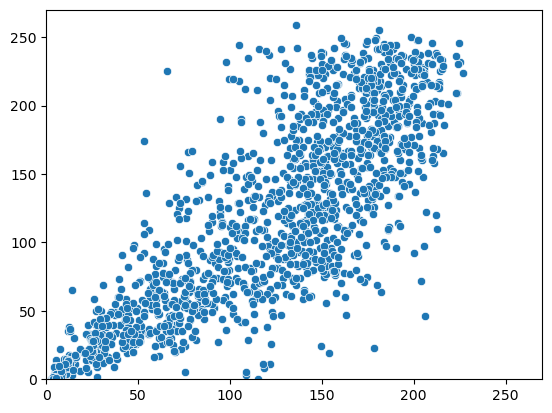

In [27]:
sns.scatterplot(y_pred_forest,y_test)
plt.xlim(0,270)
plt.ylim(0,270)

### KNN

In [71]:
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col
player_pos = X_test.pos_col

X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('knn',KNeighborsRegressor())
])

grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'knn__n_neighbors':[30,40]
#     'forest__criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
#     'forest__max_depth':[4,12,None],
#     'forest__min_samples_split':[1,2,3],
#     'forest__min_samples_leaf':[1,2,3]
}

knn = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [72]:
knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_test)
print(r2_score(y_test,y_pred),mean_squared_error(y_test,y_pred));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\

0.49868519271605993 2488.4851741664374


In [ ]:
sns.scatterplot(y_pred_knn,y_test)
plt.xlim(0,270)
plt.ylim(0,270)

### Decision Tree

In [73]:
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col
player_pos = X_test.pos_col

X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('tree',DecisionTreeRegressor(random_state=42))
])

grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)]
#     'tree__n_estimators':[75,100,125],
#     'tree__criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
#     'tree__max_depth':[4,12,None],
#     'tree__min_samples_split':[1,2,3],
#     'tree__min_samples_leaf':[1,2,3]
}

tree = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [74]:
tree.fit(X_train,y_train)
y_pred_tree = tree.predict(X_test)
print(r2_score(y_test,y_pred_tree),mean_squared_error(y_test,y_pred_tree));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\a

0.3335330887272139 3308.2865370770337


In [ ]:
sns.scatterplot(y_pred_tree,y_test)
plt.xlim(0,270)
plt.ylim(0,270);

### XGBoost

In [25]:
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col
player_pos = X_test.pos_col

X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('xgb',XGBRegressor())
])

grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'xgb__max_depth':[3,2,1],
    'xgb__eta':[.22,.23,.24],
    'xgb__gamma':[0,1,2]
#     'forest__min_samples_split':[1,2,3],
#     'forest__min_samples_leaf':[1,2,3]
}

xgb = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [29]:
xgb.best_params_

{'sample': RandomOverSampler(random_state=42),
 'xgb__eta': 0.23,
 'xgb__gamma': 0,
 'xgb__max_depth': 1}

In [26]:
start_time = time.time()
xgb.fit(X_train,y_train)
print(((time.time() - start_time)/60),'minutes')
y_pred_xgb = xgb.predict(X_test)
print(r2_score(y_test,y_pred_xgb),mean_squared_error(y_test,y_pred_xgb));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
135 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\cap

4.076668107509613 minutes
0.6360774994869666 1806.4811450090062


In [ ]:
sns.scatterplot(y_pred_xgb,y_test)
plt.xlim(0,270)
plt.ylim(0,270);

### ADABoost

In [27]:
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col
player_pos = X_test.pos_col

X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('ada',AdaBoostRegressor(random_state=42))
])

grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'ada__n_estimators':[45,40],
    'ada__learning_rate':[.35,.33],
    'ada__loss':['linear','square','exponential']
#     'forest__min_samples_split':[1,2,3],
#     'forest__min_samples_leaf':[1,2,3]
}

ada = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [30]:
ada.best_params_

{'ada__learning_rate': 0.35,
 'ada__loss': 'linear',
 'ada__n_estimators': 40,
 'sample': RandomOverSampler(random_state=42)}

In [28]:
start_time = time.time()
ada.fit(X_train,y_train)
print(((time.time() - start_time)/60),'minutes')
y_pred_ada = ada.predict(X_test)
print(r2_score(y_test,y_pred_ada),mean_squared_error(y_test,y_pred_ada));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capt

6.8490630984306335 minutes
0.6331292333811261 1821.116093722432


In [ ]:
sns.scatterplot(y_pred_ada,y_test)
plt.xlim(0,270)
plt.ylim(0,270);

### GradientBoost

In [61]:
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col
player_pos = X_test.pos_col

X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('grad',GradientBoostingRegressor(random_state=42))
])

grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'grad__n_estimators':[94],
    'grad__learning_rate':[.05],
#     'grad__loss':['absolute_error','squared_error','huber','quantile'],
    'grad__min_samples_split':[2],
    'grad__min_samples_leaf':[1],
    'grad__max_depth':[4],
    'grad__min_impurity_decrease':[.31]
}

grad = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [62]:
start_time = time.time()
grad.fit(X_train,y_train)
print(((time.time() - start_time)/60),'minutes')
y_pred_grad = grad.predict(X_test)
print(r2_score(y_test,y_pred_grad),mean_squared_error(y_test,y_pred_grad));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\a

0.8689370671908061 minutes
0.6524671286024645 1725.1243838054565


In [55]:
grad.best_params_

{'grad__learning_rate': 0.05,
 'grad__max_depth': 4,
 'grad__min_impurity_decrease': 0.31,
 'grad__min_samples_leaf': 1,
 'grad__min_samples_split': 2,
 'grad__n_estimators': 94,
 'sample': RandomOverSampler(random_state=42)}

In [58]:
y_test

array([199, 151, 127, ..., 204,  71, 199])

In [59]:
y_pred_grad

array([208.03100677, 131.51236289, 176.39989632, ..., 199.99995066,
        60.21004735, 161.54142836])

In [63]:
player_pos

1073    DB
144     QB
2380    OL
184     RB
2587    LB
        ..
2282    WR
2986    DT
1078    DT
1413    LB
2696    OL
Name: pos_col, Length: 1389, dtype: object

In [65]:
y_test

array([199, 151, 127, ..., 204,  71, 199])

In [61]:
results = pd.concat([player_name.reset_index(),player_round.reset_index(),player_year.reset_index(),X_test.reset_index(),pd.Series(y_pred_forest),pd.Series(y_test)],axis=1)

In [62]:
results

,index,player_col,index,Round_col,index,year_col,index,weight_x_col,height_x_col,pos_rk_col,...,valu,versatil,well,work,yard,year,year starter,zone,0,1
0,1073,DeAndre Wright,1073,6,1073,2009.0,1073,198.0,70.750,41.0,...,0.00000,0.000000,0.287967,0.000000,0.000000,0.000000,0.000000,0.0,192.316674,199
1,144,Adrian McPherson,144,5,144,2005.0,144,218.0,75.500,9.0,...,0.00000,0.000000,0.098724,0.000000,0.000000,0.083411,0.000000,0.0,115.573295,151
2,2380,Jon Feliciano,2380,4,2380,2015.0,2380,323.0,75.875,17.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,176.117134,127
3,184,DeAndra Cobb,184,6,184,2005.0,184,196.0,69.750,24.0,...,0.00000,0.082646,0.000000,0.000000,0.218138,0.063405,0.000000,0.0,182.881615,200
4,2587,Kyler Fackrell,2587,3,2587,2016.0,2587,245.0,77.000,10.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,142.796157,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384,2282,Phillip Dorsett,2282,1,2282,2015.0,2282,185.0,69.750,6.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,22.607580,28
1385,2986,Treyvon Hester,2986,7,2986,2017.0,2986,300.0,74.375,20.0,...,0.19871,0.000000,0.000000,0.165464,0.000000,0.250062,0.179509,0.0,184.156011,243
1386,1078,Ra'Shon Harris,1078,6,1078,2009.0,1078,298.0,75.750,24.0,...,0.00000,0.000000,0.000000,0.404393,0.000000,0.000000,0.000000,0.0,179.050337,204
1387,1413,Martez Wilson,1413,3,1413,2011.0,1413,250.0,76.000,4.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,66.054010,71


In [63]:
results['difference'] = results[0] - results[1]
results['abs_difference'] = (results[0] - results[1]).abs()

In [48]:
results.difference

0       -6.683326
1      -35.426705
2       49.117134
3      -17.118385
4       55.796157
          ...    
1384    -5.392420
1385   -58.843989
1386   -24.949663
1387    -4.945990
1388   -35.013169
Name: difference, Length: 1389, dtype: float64

In [65]:
results.abs_difference.mean()

31.148197003071516

<AxesSubplot:xlabel='abs_difference', ylabel='Count'>

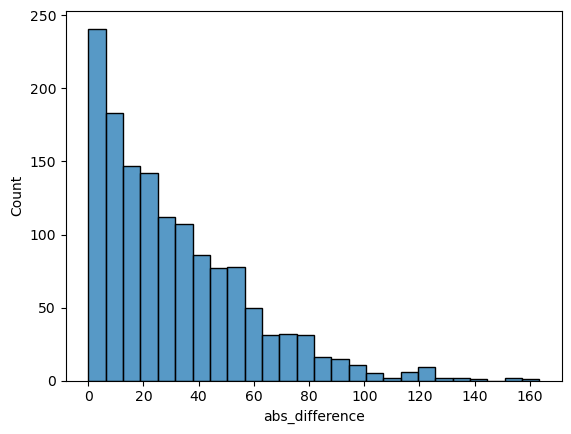

In [66]:
sns.histplot(results.abs_difference)

In [67]:
best = results[results.abs_difference <= 16]

In [98]:
best

,index,player_col,index,Round_col,index,year_col,index,weight_x_col,height_x_col,pos_rk_col,...,well,work,yard,year,year starter,zone,0,1,difference,abs_difference
0,1073,DeAndre Wright,1073,6,1073,2009.0,1073,198.0,70.750,41.0,...,0.287967,0.0,0.000000,0.000000,0.0,0.0,192.316674,199,-6.683326,6.683326
5,2768,Charles Harris,2768,1,2768,2017.0,2768,253.0,74.750,1.0,...,0.000000,0.0,0.000000,0.273181,0.0,0.0,30.338650,21,9.338650,9.338650
9,2862,Mack Hollins,2862,4,2862,2017.0,2862,221.0,76.000,10.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,107.272818,117,-9.727182,9.727182
11,3290,Irv Smith Jr.,3290,2,3290,2019.0,3290,242.0,74.375,3.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,39.745480,49,-9.254520,9.254520
12,3281,Dalton Risner,3281,2,3281,2019.0,3281,312.0,76.750,5.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,41.490994,40,1.490994,1.490994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,3053,D.J. Chark,3053,2,3053,2018.0,3053,199.0,74.875,6.0,...,0.000000,0.0,0.422382,0.000000,0.0,0.0,55.916364,60,-4.083636,4.083636
1379,2042,Brandin Cooks,2042,1,2042,2014.0,2042,189.0,69.750,4.0,...,0.398851,0.0,0.000000,0.000000,0.0,0.0,21.477009,19,2.477009,2.477009
1380,1632,Casey Hayward,1632,2,1632,2012.0,1632,192.0,71.375,8.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,63.745515,61,2.745515,2.745515
1384,2282,Phillip Dorsett,2282,1,2282,2015.0,2282,185.0,69.750,6.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,22.607580,28,-5.392420,5.392420


In [68]:
worst = results[results.abs_difference >= 64]

In [69]:
best.Round_col.value_counts(normalize=True)

1    0.263889
5    0.160714
6    0.154762
2    0.154762
3    0.123016
4    0.115079
7    0.027778
Name: Round_col, dtype: Float64

In [58]:
worst.Round_col.value_counts(normalize=True)

7     0.3375
3       0.25
6      0.125
2    0.09375
1    0.08125
5    0.05625
4    0.05625
Name: Round_col, dtype: Float64

In [101]:
best_pos = best.pos_col.value_counts(normalize=True) - results.pos_col.value_counts(normalize=True)
worst_pos = worst.pos_col.value_counts(normalize=True) - results.pos_col.value_counts(normalize=True)

In [100]:
best_pos.sort_values(ascending=False)

DE    0.019310
WR    0.018114
OL    0.003818
P     0.003441
LS    0.001808
FB    0.000544
DT    0.000189
QB   -0.000424
K    -0.000527
CB   -0.002250
DL   -0.003231
TE   -0.004761
RB   -0.005764
DB   -0.006257
S    -0.008588
LB   -0.015423
Name: pos_col, dtype: float64

In [102]:
worst_pos.sort_values(ascending=False)

DB    0.028069
CB    0.024834
S     0.023853
OL    0.006794
DT    0.006637
K     0.006021
DL    0.005301
LB    0.000450
P    -0.000229
QB   -0.010246
WR   -0.012540
DE   -0.019083
TE   -0.019146
RB   -0.037113
FB         NaN
LS         NaN
Name: pos_col, dtype: float64

In [71]:
results.pos_col.value_counts(normalize=True)

OL    0.180706
LB    0.124550
WR    0.118790
DB    0.109431
DE    0.087833
RB    0.087113
DT    0.087113
QB    0.053996
TE    0.050396
CB    0.043916
S     0.032397
DL    0.007199
K     0.006479
P     0.006479
LS    0.002160
FB    0.001440
Name: pos_col, dtype: float64

In [72]:
best.pos_col.value_counts(normalize=True)

OL    0.184524
WR    0.136905
LB    0.109127
DE    0.107143
DB    0.103175
DT    0.087302
RB    0.081349
QB    0.053571
TE    0.045635
CB    0.041667
S     0.023810
P     0.009921
K     0.005952
LS    0.003968
DL    0.003968
FB    0.001984
Name: pos_col, dtype: float64

In [73]:
worst.pos_col.value_counts(normalize=True)

OL    0.18750
DB    0.13750
LB    0.12500
WR    0.10625
DT    0.09375
CB    0.06875
DE    0.06875
S     0.05625
RB    0.05000
QB    0.04375
TE    0.03125
K     0.01250
DL    0.01250
P     0.00625
Name: pos_col, dtype: float64

<AxesSubplot:xlabel='abs_difference', ylabel='Count'>

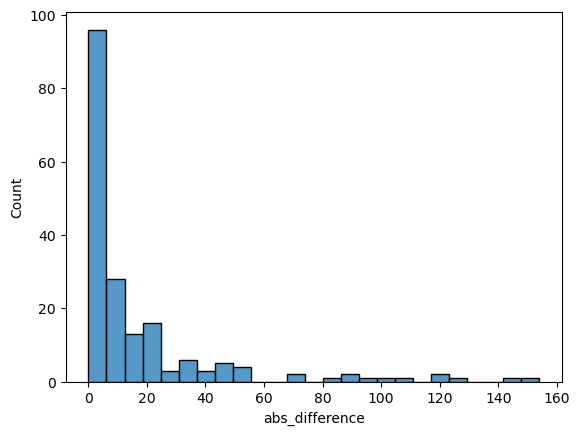

In [86]:
sns.histplot(results[results.Round_col == 1].abs_difference)

In [90]:
one_round.develop

5       0.000000
21      0.000000
25      0.065799
31      0.155973
34      0.000000
          ...   
1349    0.000000
1371    0.000000
1373    0.000000
1379    0.000000
1384    0.000000
Name: develop, Length: 187, dtype: float64

In [91]:
miss_one = one_round[one_round.abs_difference > 32]

In [95]:
miss_one.develop.mean()

0.05798920461731297

In [96]:
one_round.develop.mean()

0.030089307317340747

In [80]:
results[results.Round_col == 2].abs_difference.mean()

26.599156011760396

In [81]:
results[results.Round_col == 3].abs_difference.mean()

37.47135828617434

In [82]:
results[results.Round_col == 4].abs_difference.mean()

29.98975026380707

In [83]:
results[results.Round_col == 5].abs_difference.mean()

25.747143312402958

In [84]:
results[results.Round_col == 6].abs_difference.mean()

28.15980736614219

In [85]:
results[results.Round_col == 7].abs_difference.mean()

53.2784548439963